# 8.4 Generating images with variational autoencoders
Sampling from a collection of images to create entirely new images or edit existing ones is currently the most popular and successful application of creative AI. In this section, we’ll look at concepts pertaining to image generation, alongside implementation details relative to the two main techniques in this domain: variational autoencoders (VAEs) and generative adversarial networks (GANs). Creating new images is not the only thing these techniques are capable of producing — one could also create sound, music, or even text.

## 8.4.1 Sampling from latent spaces of images
The main concept of image generation is to develop a low-dimensional latent space of representations where any point can be mapped to a realistic-looking image. The module capable of realizing this mapping, taking as input a latent point and outputting an image (a grid of pixels), is called a generator (in the case of GANs) or a decoder (in the case of VAEs). Once such a latent space has been developed, you can sample points from it, and generate images that have never been seen before.

![latent](images/8_4_1_latent.jpg)

GANs and VAEs are two different strategies for learning such latent spaces of image representations. Variational Autoencoders are great for learning latent spaces that are well structured. General Adversarial Networks generate images that can potentially be highly realistic, but the latent space they come from may not have as much structure and continuity. An example of faces generated using VAEs is shown below.

![vae](images/8_4_1_vae.png)

## 8.4.2 Concept vectors for image editing
Given a latent space of representations, or an embedding space, certain directions in the space may encode interesting axes of variation in the original data. In a latent space of images of faces, for instance, there may be a smile vector, such that if latent point z is the embedded representation of a certain face, then latent point z + s is the embedded representation of the same face, smiling. In the case of faces, you may discover vectors for adding sunglasses to a face, removing glasses, turning a male face into a female face, and so on. The image below is an example of a smile vector using VAEs trained on a dataset of faces of celebrities (the CelebA dataset).

![smile](images/8_4_2_smile.png)

## 8.4.3 Variational Autoencoders
Variational autoencoders are a kind of generative model that’s is appropriate for the task of image editing via concept vectors. They’re a modern take on autoencoders and mixes ideas from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the original image, via a decoder module (see figure 8.12). An autoencoder is made of two components. The encoder brings the data from a high dimensional input to a bottleneck layer, where the number of neurons is the smallest. Then, the decoder takes this encoded input and converts it back to the original input shape — in our case an image. The latent space is the space in which the data lies in the bottleneck layer.

So...what the hell does this mean? Let's an encoder receives a color image. To convert the color image into numerical values, the encoder must convert the image to grayscale - where 0 is white and 100 is black with varying shades of gray in between. You must be thinking, *but a color image isn't on a grayscale*, and you are right, but we have a trick for that shown below. The encoder splits the RGB images into 3 new images for each shade - Red, Green, and Blue.

[rgb_example](images/8_4_3_rgb_example.png)

Once the encoder has converted an input image into a bunch of numerical values, it then compresses the high-dimensional image into a 1D-vector which is essentially a long, single file line of numbers - each number representing a grayscale value of the pixels shade. This long, single file line of numbers is known as the image **latent space**. Here's a good visualization below.

[latent2](images/8_4_3_later.png)

The encoder is then trained using the exact same input images as its target output, meaning the autoencoder learns to reconstruct the original inputs - i.e. recreate the original image. By imposing various constraints on the code (the output of the encoder), we can get the autoencoder to learn interesting latent representations of the data. Most commonly, we will constrain the code to be low-dimensional and sparse (mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

![autoencoder](images/8_4_3_autoencoder.jpg)

In practice, such classical autoencoders don’t lead to particularly great results. They’re not much good at compression, either. For these reasons, they have largely fallen out of fashion. VAEs, however, augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed code in the latent space, turns the image into the parameters of a statistical distribution: a mean and a variance. Essentially, this means you’re assuming the input image has been generated by a statistical process, and that the randomness of this process should be taken into account during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input (see figure 8.13). The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.

![vae](images/8_4_3_vae.jpg)

In technical terms, here’s how a VAE works:

 1. An encoder module turns the input samples input_img into two parameters in a latent space of representations, z_mean and z_log_variance.
 2. You randomly sample a point z from the latent normal distribution that’s assumed to generate the input image, via z = z_mean + exp(z_log_variance) * epsilon, where epsilon is a random tensor of small values.
 3. A decoder module maps this point in the latent space back to the original input image.

Because epsilon is random, the process ensures that every point that’s close to the latent location where you encoded input_img (z-mean) can be decoded to something similar to input_img, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the initial inputs, and a regularization loss that helps learn well-formed latent spaces and reduce overfitting to the training data. Let’s quickly go over a Keras implementation of a VAE. Schematically, it looks like this:

`z_mean, z_log_variance = encoder(input_img)`

`z = z_mean + exp(z_log_variance) * epsilon`

`reconstructed_img = decoder(z)`

`model = Model(input_img, reconstructed_img)`

You can then train the model using the reconstruction loss and the regularization loss.

The following listing shows the encoder network you’ll use, mapping images to the parameters of a probability distribution over the latent space. It’s a simple convnet that maps the input image x to two vectors, z_mean and z_log_var.

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next is the code for using z_mean and z_log_var, the parameters of the statistical distribution assumed to have produced input_img, to generate a latent space point z. Here, you wrap some arbitrary code (built on top of Keras backend primitives) into a Lambda layer. In Keras, everything needs to be a layer, so code that isn’t part of a built-in layer should be wrapped in a Lambda (or in a custom layer).

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

The following listing shows the decoder implementation. You reshape the vector z to the dimensions of an image and then use a few convolution layers to obtain a final image output that has the same dimensions as the original input_img.

In [3]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

The dual loss of a VAE doesn’t fit the traditional expectation of a sample-wise function of the form loss(input, target). Thus, you’ll set up the loss by writing a custom layer that internally uses the built-in add_loss layer method to create an arbitrary loss.

In [4]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])


Finally, you’re ready to instantiate and train the model. Because the loss is taken care of in the custom layer, you don’t specify an external loss at compile time (loss=None), which in turn means you won’t pass target data during training (as you can see, you only pass x_train to the model in fit).

In [5]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

Once such a model is trained—on MNIST, in this case—you can use the decoder network to turn arbitrary latent space vectors into images.

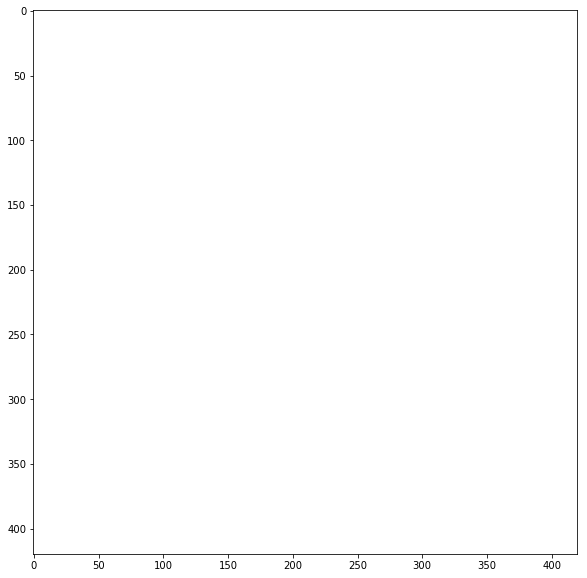

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show();

The grid of sampled digits below shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a path through latent space. Specific directions in this space have a meaning: for example, there’s a direction for “four-ness,” “one-ness,” and so on.

![mnist](images/8_4_3_mnist.png)

In the next section, we’ll cover the other major tool for generating artificial images: generative adversarial networks (GANs).

8.4.4. Wrapping up
 - Image generation with deep learning is done by learning latent spaces that capture statistical information about a dataset of images. By sampling and decoding points from the latent space, you can generate never-before-seen images. There are two major tools to do this: VAEs and GANs.
 - VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of image editing in latent space: face swapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing latent-space-based animations, such as animating a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way.
 - GANs enable the generation of realistic single-frame images but may not induce latent spaces with solid structure and high continuity.
 - Most successful practical applications I have seen with images rely on VAEs, but GANs are extremely popular in the world of academic research—at least, circa 2016–2017. You’ll find out how they work and how to implement one in the next section.